# Gravitational Waves Time Series Classification

write something

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torch.utils.data import Dataset

from utils import dataset, plots

In [ ]:
n_classes = 3
std = False

## Data

write something

In [3]:
valid_set = dataset.GW_dataset('validation', n_classes=n_classes, std=std)

In [16]:
all_samples = {label: [] for label in range(n_classes)}

for data, label in valid_set:
    data = data.reshape(2048)
    amplitude = data.abs().max().item()
    all_samples[label].append((amplitude, data))

# for each class, sort by amplitude and keep the top 10
timeseries = {
    label: [d for _, d in sorted(samples, key=lambda x: -x[0])[:20]]
    for label, samples in all_samples.items()
}

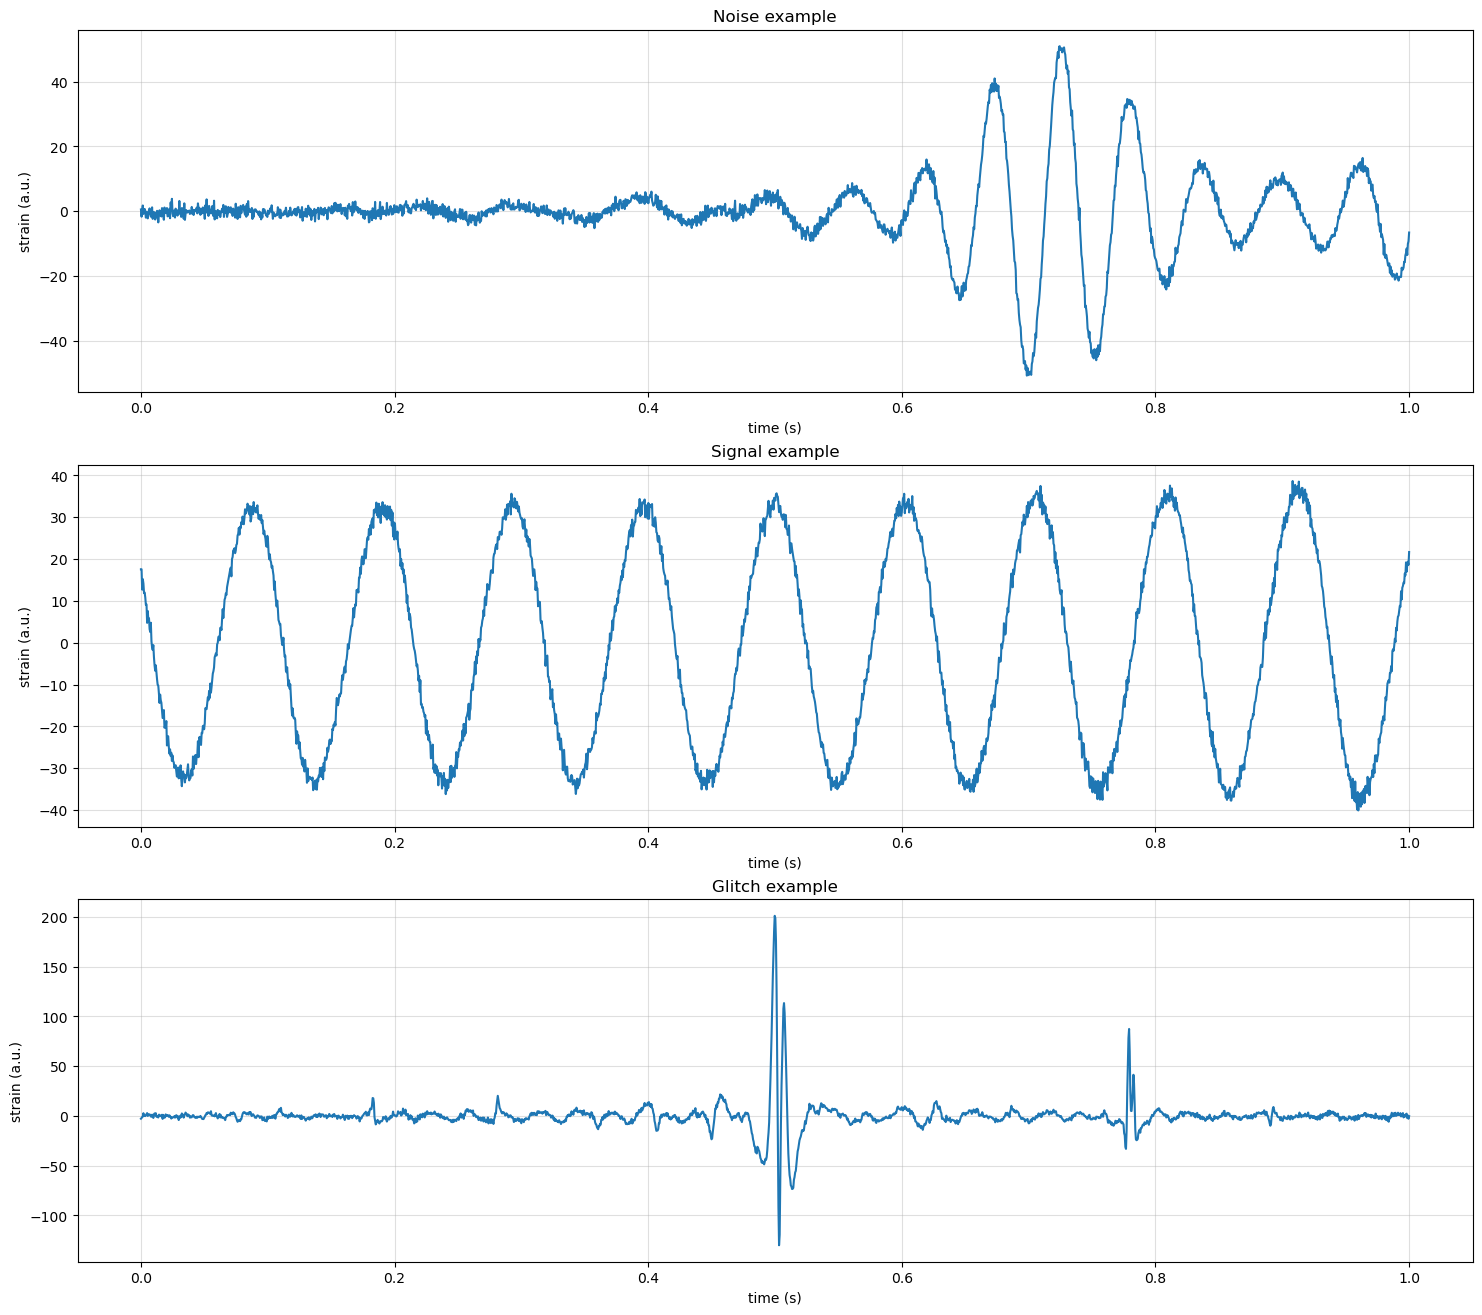

In [19]:
ts1 = [timeseries[0][1], timeseries[1][18], timeseries[2][2]]
plots.plot_TS(ts1)

In [4]:
# Define target amplitudes per label
target_amplitude = {0: 5, 1: 6, 2: 25}

# Collect all samples per class
all_samples = {label: [] for label in range(n_classes)}

for data, label in valid_set:
    data = data.reshape(2048)
    amplitude = data.abs().max().item()
    target = target_amplitude.get(label, None)

    if target is not None:
        # Store distance to target
        distance = abs(amplitude - target)
        all_samples[label].append((distance, data, amplitude))

# For each class, sort by closeness to target amplitude and keep the best 3
timeseries = {
    label: [d for _, d, _ in sorted(samples, key=lambda x: x[0])[:3]]
    for label, samples in all_samples.items()
}

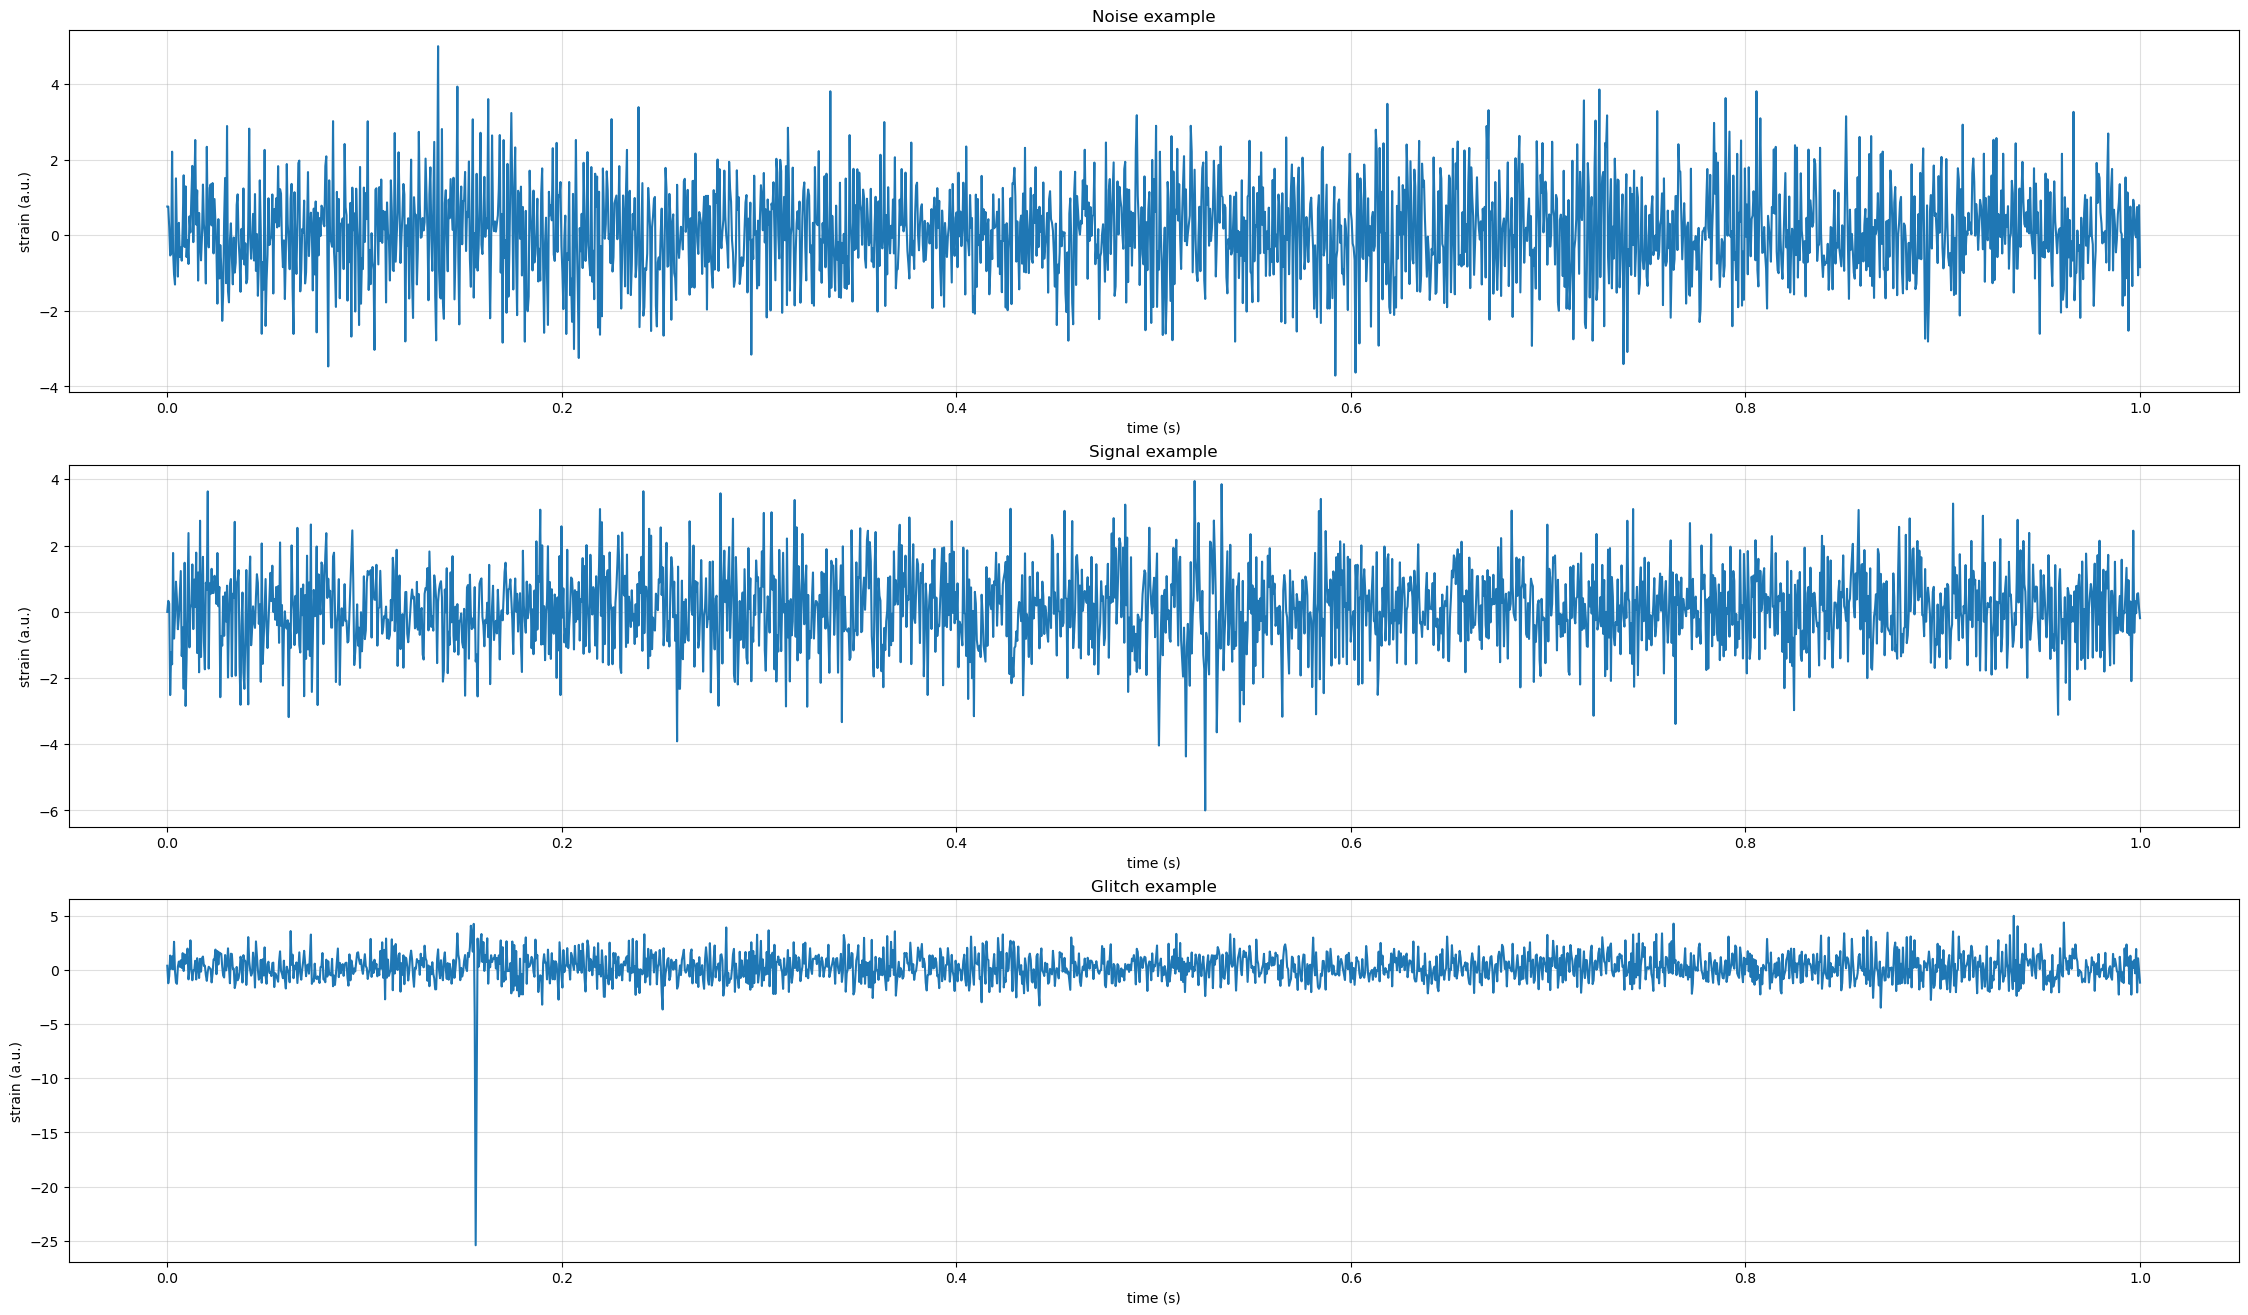

In [5]:
ts2 = [timeseries[0][0], timeseries[1][2], timeseries[2][0]]
plots.plot_TS(ts2)

## CNN

## TCN

## IT